## <b>Define everything</b>



In [1]:
notebook_mode = True
viz_mode = False

In [2]:
import os
import json
import argparse
import time

import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.utils.class_weight import compute_class_weight

from tensorboardX import SummaryWriter
from fastprogress import master_bar, progress_bar

# Remove warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)

from config import *
from utils.graph_utils import *
from utils.google_tsp_reader import GoogleTSPReader
from utils.plot_utils import *
# from models.gcn_model import ResidualGatedGCNModel
from utils.model_utils import *

In [3]:
if notebook_mode == True:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('png')

/var/folders/1w/9c6ht6r16hbb25q5hfmh8ttm0000gn/T/ipykernel_32599/3855748638.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


In [4]:
if notebook_mode==False:
    parser = argparse.ArgumentParser(description='gcn_tsp_parser')
    parser.add_argument('-c','--config', type=str, default="configs/default.json")
    args = parser.parse_args()
    config_path = args.config
elif viz_mode == True:
    config_path = "logs/tsp100/config.json"
else:
    config_path = "configs/default20.json"
    # config_path = "configs/tsp20.json"

config = get_config(config_path)
print("Loaded {}:\n{}".format(config_path, config))

Loaded configs/default20.json:
{'expt_name': 'deafult', 'gpu_id': '0', 'train_filepath': './data/tsp20_train_concorde.txt', 'val_filepath': './data/tsp20_val_concorde.txt', 'test_filepath': './data/tsp20_test_concorde.txt', 'num_nodes': 20, 'num_neighbors': 5, 'node_dim': 2, 'voc_nodes_in': 2, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 2, 'beam_size': 10, 'hidden_dim': 50, 'num_layers': 3, 'mlp_layers': 2, 'aggregation': 'mean', 'max_epochs': 15, 'val_every': 5, 'test_every': 100, 'batch_size': 3, 'batches_per_epoch': 16, 'accumulation_steps': 1, 'learning_rate': 0.001, 'decay_rate': 1.01}


In [5]:
# Over-ride config params (for viz_mode)
if viz_mode==True:
    config.gpu_id = "0"
    config.batch_size = 1
    config.accumulation_steps = 1
    config.beam_size = 1280
    
    # Uncomment below to evaluate generalization to variable sizes in viz_mode
#     config.num_nodes = 50
#     config.num_neighbors = 20
#     config.train_filepath = f"./data/tsp{config.num_nodes}_train_concorde.txt"
#     config.val_filepath = f"./data/tsp{config.num_nodes}_val_concorde.txt"
#     config.test_filepath = f"./data/tsp{config.num_nodes}_test_concorde.txt"

Configure GPU Options

In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(config.gpu_id)  

In [7]:
if torch.cuda.is_available():
    print("CUDA available, using GPU ID {}".format(config.gpu_id))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print("CUDA not available")
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

CUDA not available


Number of batches of size 3: 333333
Batch generation took: 0.001 sec
edges: (3, 20, 20)
edges_values: (3, 20, 20)
edges_targets: (3, 20, 20)
nodes: (3, 20)
nodes_target: (3, 20)
nodes_coord: (3, 20, 2)
tour_nodes: (3, 20)
tour_len: (3,)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0.

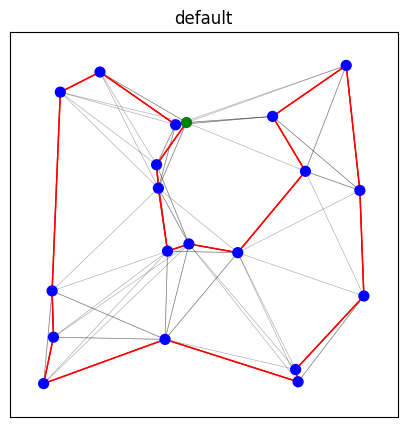

In [8]:
if notebook_mode:
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    batch_size = config.batch_size
    train_filepath = config.train_filepath
    dataset = GoogleTSPReader(num_nodes, num_neighbors, batch_size, train_filepath)
    print("Number of batches of size {}: {}".format(batch_size, dataset.max_iter))

    t = time.time()
    batch = next(iter(dataset))  # Generate a batch of TSPs
    print("Batch generation took: {:.3f} sec".format(time.time() - t))

    print("edges:", batch.edges.shape)
    print("edges_values:", batch.edges_values.shape)
    print("edges_targets:", batch.edges_target.shape)
    print("nodes:", batch.nodes.shape)
    print("nodes_target:", batch.nodes_target.shape)
    print("nodes_coord:", batch.nodes_coord.shape)
    print("tour_nodes:", batch.tour_nodes.shape)
    print("tour_len:", batch.tour_len.shape)

    idx = 0
    f = plt.figure(figsize=(5, 5))
    a = f.add_subplot(111)
    plot_tsp(a, batch.nodes_coord[idx], batch.edges[idx], batch.edges_values[idx], batch.edges_target[idx])
    print(batch.edges_target[idx])

In [9]:
import random

def divise_the_TSP(batch, n_instances, n_nodes):
    """_summary_

    Args:
        batch (the TSP): shape (n_nodes) ? 
        n_instances (n): _description_
        n_nodes (_type_): _description_
    """
    nodes_original_TSP = batch.shape[1]
    extracts = []
    TSP_instance = []
    for i in range(n_instances):
        extraction = random.sample(range(nodes_original_TSP), n_nodes)
        extraction.sort()
        extracts += extraction
        edges_k_means =  batch.edges[0]
        extract_edges_k_means = edges_k_means[np.ix_(extraction, extraction)]
        edges_dist =  batch.edges[0]
        extract_edges_dist = edges_dist[np.ix_(extraction, extraction)]
        nodes = batch.nodes[0]
        nodes_coord_extraction = nodes[np.isin(np.arange(nodes.shape[0]), extraction), :]
        
        extract_edges_k_means = Variable(torch.LongTensor(extract_edges_k_means).type(dtypeFloat), requires_grad=False)
        extract_edges_dist = Variable(torch.FloatTensor(extract_edges_dist).type(dtypeFloat), requires_grad=False)
        nodes_coord_extraction = Variable(torch.FloatTensor(nodes_coord_extraction).type(dtypeFloat), requires_grad=False)
        
        TSP_instance.append([extract_edges_k_means, extract_edges_dist, nodes_coord_extraction])
    
    return TSP_instance, extracts
        
def aggregate_result(tab_y_pred, tab_extrac, true_size):
    counts = np.zeros_like()
    y_pred_f = np.zeros((true_size, true_size))
    for i in range(len(tab_extrac)):
        temp = np.zeros((true_size, true_size))
        temp[np.ix_(tab_extrac[i], tab_extrac[i])] = tab_y_pred[i]
        y_pred_f += temp
        counts += np.where(temp != 0, 1, 0)
    # Si on a pas de valeur on initialise a 1/2:
    no_val = np.where(temp != 0, 0, 1/2)
    y_pred_f = y_pred_f/counts + no_val
    return y_pred_f


## <b>Define and train the model</b>

In [10]:
from models.model import MainModel

In [11]:
if notebook_mode == True:
    # Instantiate the network
    net = nn.DataParallel(MainModel(config))
    if torch.cuda.is_available():
        net.cuda()
    print(net)

    # Compute number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('Number of parameters:', nb_param)
    
    # Define optimizer
    learning_rate = config.learning_rate
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    print(optimizer)

DataParallel(
  (module): MainModel(
    (NodesEncoding): NodesEncodeur(
      (A1): Linear(in_features=2, out_features=50, bias=True)
    )
    (EdgesEncoding): EdgesEncodeur(
      (A2): Linear(in_features=1, out_features=25, bias=True)
      (A3): Linear(in_features=1, out_features=25, bias=True)
    )
    (gcn_layers): ModuleList(
      (0): HiddenLayer(
        (bnNodes): BatchNormNodes(
          (W1): Linear(in_features=50, out_features=50, bias=False)
          (W2): Linear(in_features=50, out_features=50, bias=False)
          (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (bnEdges): BatchNormEdges(
          (W3): Linear(in_features=50, out_features=50, bias=False)
          (W4): Linear(in_features=50, out_features=50, bias=False)
          (W5): Linear(in_features=50, out_features=50, bias=False)
          (batch_norm): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )

In [12]:
if notebook_mode == True and viz_mode == False:
    # Generate a batch of TSPs
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    batch_size = config.batch_size
    train_filepath = config.train_filepath
    dataset = iter(GoogleTSPReader(num_nodes, num_neighbors, batch_size, train_filepath))
    batch = next(dataset)

    # Convert batch to torch Variables
    edges_k_means = Variable(torch.LongTensor(batch.edges).type(dtypeFloat), requires_grad=False)
    edges_dist = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
    x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeFloat), requires_grad=False)
    nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
    y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeFloat), requires_grad=False)
    y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeFloat), requires_grad=False)
    
    # Compute class weights
    edge_labels = y_edges.cpu().numpy().flatten()
    edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
    print("Class weights: {}".format(edge_cw))
        
    # Forward pass
    y_preds, loss = net.forward(nodes_coord, edges_dist, edges_k_means, y_edges, edge_cw)

    # y_edges = y_edges.long()
    
    # edge_cw = torch.Tensor(edge_cw).type(dtypeFloat)  # Convert to tensors
    # loss = loss_edges(y_preds, y_edges, edge_cw)
    
    loss = loss.mean()
    print("Output size: {}".format(y_preds.size()))
    print("Loss value:", loss)

Class weights: [0.55555556 5.        ]
Output size: torch.Size([3, 20, 20, 2])
Loss value: tensor(0.7963, grad_fn=<MeanBackward0>)


In [13]:
def train_one_epoch(net, optimizer, config, master_bar):
    # Set training mode
    net.train()

    # Assign parameters
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    train_filepath = config.train_filepath

    # Load TSP data
    dataset = GoogleTSPReader(num_nodes, num_neighbors, batch_size, train_filepath)
    if batches_per_epoch != -1:
        batches_per_epoch = min(batches_per_epoch, dataset.max_iter)
    else:
        batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    # running_err_edges = 0.0
    # running_err_tour = 0.0
    # running_err_tsp = 0.0
    running_pred_tour_len = 0.0
    running_gt_tour_len = 0.0
    running_nb_data = 0
    running_nb_batch = 0

    start_epoch = time.time()
    for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
        # Generate a batch of TSPs
        try:
            batch = next(dataset)
        except StopIteration:
            break

        # Convert batch to torch Variables
        edges_k_means = Variable(torch.LongTensor(batch.edges).type(dtypeFloat), requires_grad=False)
        edges_dist = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeFloat), requires_grad=False)
        nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
        y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeFloat), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeFloat), requires_grad=False)
        
        # Compute class weights (if uncomputed)
        if type(edge_cw) != torch.Tensor:
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        
        # Forward pass
        y_preds, loss = net.forward(nodes_coord, edges_dist, edges_k_means, y_edges, edge_cw)
        loss = loss.mean()  # Take mean of loss across multiple GPUs
        loss = loss / accumulation_steps  # Scale loss by accumulation steps
        loss.backward()
            

        # Backward pass
        if (batch_num+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Compute error metrics and mean tour lengths
        # err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)
        pred_tour_len = mean_tour_len_edges(edges_dist, y_preds)
        gt_tour_len = np.mean(batch.tour_len)

        # Update running data
        running_nb_data += batch_size
        running_loss += batch_size* loss.data.item()* accumulation_steps  # Re-scale loss
        # running_err_edges += batch_size* err_edges
        # running_err_tour += batch_size* err_tour
        # running_err_tsp += batch_size* err_tsp
        running_pred_tour_len += batch_size* pred_tour_len
        running_gt_tour_len += batch_size* gt_tour_len
        running_nb_batch += 1
        
        # Log intermediate statistics
        result = ('loss:{loss:.4f} pred_tour_len:{pred_tour_len:.3f} gt_tour_len:{gt_tour_len:.3f}'.format(
            loss=running_loss/running_nb_data,
            pred_tour_len=running_pred_tour_len/running_nb_data,
            gt_tour_len=running_gt_tour_len/running_nb_data))
        master_bar.child.comment = result

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0 # running_err_edges/ running_nb_data
    err_tour = 0 # running_err_tour/ running_nb_data
    err_tsp = 0 # running_err_tsp/ running_nb_data
    pred_tour_len = running_pred_tour_len/ running_nb_data
    gt_tour_len = running_gt_tour_len/ running_nb_data

    return time.time()-start_epoch, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len


def metrics_to_str(epoch, time, learning_rate, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len):
    result = ( 'epoch:{epoch:0>2d}\t'
               'time:{time:.1f}h\t'
               'lr:{learning_rate:.2e}\t'
               'loss:{loss:.4f}\t'
               # 'err_edges:{err_edges:.2f}\t'
               # 'err_tour:{err_tour:.2f}\t'
               # 'err_tsp:{err_tsp:.2f}\t'
               'pred_tour_len:{pred_tour_len:.3f}\t'
               'gt_tour_len:{gt_tour_len:.3f}'.format(
                   epoch=epoch,
                   time=time/3600,
                   learning_rate=learning_rate,
                   loss=loss,
                   # err_edges=err_edges,
                   # err_tour=err_tour,
                   # err_tsp=err_tsp,
                   pred_tour_len=pred_tour_len,
                   gt_tour_len=gt_tour_len))
    return result

Evaluation Loop (for validation and test sets)

In [14]:
def test(net, config, master_bar, mode='test'):
    # Set evaluation mode
    net.eval()

    # Assign parameters
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    beam_size = config.beam_size
    val_filepath = config.val_filepath
    test_filepath = config.test_filepath

    # Load TSP data
    if mode == 'val':
        dataset = GoogleTSPReader(num_nodes, num_neighbors, batch_size=batch_size, filepath=val_filepath)
    elif mode == 'test':
        dataset = GoogleTSPReader(num_nodes, num_neighbors, batch_size=batch_size, filepath=test_filepath)
    batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    # running_err_edges = 0.0
    # running_err_tour = 0.0
    # running_err_tsp = 0.0
    running_pred_tour_len = 0.0
    running_gt_tour_len = 0.0
    running_nb_data = 0
    running_nb_batch = 0
    
    with torch.no_grad():
        start_test = time.time()
        for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
            # Generate a batch of TSPs
            try:
                batch = next(dataset)
            except StopIteration:
                break

            # Convert batch to torch Variables
            edges_k_means = Variable(torch.LongTensor(batch.edges).type(dtypeFloat), requires_grad=False)
            edges_dist = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
            x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeFloat), requires_grad=False)
            nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
            y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeFloat), requires_grad=False)
            y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeFloat), requires_grad=False)
            
            # Compute class weights (if uncomputed)
            if type(edge_cw) != torch.Tensor:
                edge_labels = y_edges.cpu().numpy().flatten()
                edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
            
            # Forward pass
            y_preds, loss = net.forward(nodes_coord, edges_dist, edges_k_means, y_edges, edge_cw)
            loss = loss.mean()  # Take mean of loss across multiple GPUs

            # Compute error metrics
            # err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)

            # Get batch beamsearch tour prediction
            if mode == 'val':  # Validation: faster 'vanilla' beamsearch
                bs_nodes = beamsearch_tour_nodes(
                    y_preds, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
            elif mode == 'test':  # Testing: beamsearch with shortest tour heuristic 
                bs_nodes = beamsearch_tour_nodes_shortest(
                    y_preds, edges_dist, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
            elif mode == 'greedy':  # Validation: faster 'vanilla' beamsearch
                bs_nodes = beamsearch_tour_nodes(
                    y_preds, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
            
            # Compute mean tour length
            pred_tour_len = mean_tour_len_nodes(edges_dist, bs_nodes)
            gt_tour_len = np.mean(batch.tour_len)

            # Update running data
            running_nb_data += batch_size
            running_loss += batch_size* loss.data.item()
            # running_err_edges += batch_size* err_edges
            # running_err_tour += batch_size* err_tour
            # running_err_tsp += batch_size* err_tsp
            running_pred_tour_len += batch_size* pred_tour_len
            running_gt_tour_len += batch_size* gt_tour_len
            running_nb_batch += 1

            # Log intermediate statistics
            result = ('loss:{loss:.4f} pred_tour_len:{pred_tour_len:.3f} gt_tour_len:{gt_tour_len:.3f}'.format(
                loss=running_loss/running_nb_data,
                pred_tour_len=running_pred_tour_len/running_nb_data,
                gt_tour_len=running_gt_tour_len/running_nb_data))
            master_bar.child.comment = result

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0 # running_err_edges/ running_nb_data
    err_tour = 0 # running_err_tour/ running_nb_data
    err_tsp = 0 # running_err_tsp/ running_nb_data
    pred_tour_len = running_pred_tour_len/ running_nb_data
    gt_tour_len = running_gt_tour_len/ running_nb_data

    return time.time()-start_test, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len

In [19]:
def main(config):
    # Instantiate the network
    net = nn.DataParallel(MainModel(config))
    if torch.cuda.is_available():
        net.cuda()
    print(net)

    # Compute number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('Number of parameters:', nb_param)
 
    # Create log directory
    log_dir = f"./logs/{config.expt_name}/"
    os.makedirs(log_dir, exist_ok=True)
    json.dump(config, open(f"{log_dir}/config.json", "w"), indent=4)
    writer = SummaryWriter(log_dir)  # Define Tensorboard writer

    # Training parameters
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    max_epochs = config.max_epochs
    val_every = config.val_every
    test_every = config.test_every
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    learning_rate = config.learning_rate
    decay_rate = config.decay_rate
    val_loss_old = 1e6  # For decaying LR based on validation loss
    best_pred_tour_len = 1e6  # For saving checkpoints

    # Define optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    print(optimizer)

    epoch_bar = master_bar(range(max_epochs))
    for epoch in epoch_bar:
        print('hey, new epoch')
        # Log to Tensorboard
        writer.add_scalar('learning_rate', learning_rate, epoch)
        
        # Train
        train_time, train_loss, train_err_edges, train_err_tour, train_err_tsp, train_pred_tour_len, train_gt_tour_len = train_one_epoch(net, optimizer, config, epoch_bar)
        print('train_one_epoch done')
        epoch_bar.write('t: ' + metrics_to_str(epoch, train_time, learning_rate, train_loss, train_err_edges, train_err_tour, train_err_tsp, train_pred_tour_len, train_gt_tour_len))
        writer.add_scalar('loss/train_loss', train_loss, epoch)
        writer.add_scalar('pred_tour_len/train_pred_tour_len', train_pred_tour_len, epoch)
        writer.add_scalar('optimality_gap/train_opt_gap', train_pred_tour_len/train_gt_tour_len - 1, epoch)
        print('writer added')

        if epoch % val_every == 0 or epoch == max_epochs-1:
            # Validate
            print('in validate, going to test, mode = val')
            val_time, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len = test(net, config, epoch_bar, mode='val')
            epoch_bar.write('v: ' + metrics_to_str(epoch, val_time, learning_rate, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len))
            writer.add_scalar('loss/val_loss', val_loss, epoch)
            writer.add_scalar('pred_tour_len/val_pred_tour_len', val_pred_tour_len, epoch)
            writer.add_scalar('optimality_gap/val_opt_gap', val_pred_tour_len/val_gt_tour_len - 1, epoch)
            
            # Save checkpoint
            if val_pred_tour_len < best_pred_tour_len:
                best_pred_tour_len = val_pred_tour_len  # Update best prediction
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                }, log_dir+"best_val_checkpoint.tar")
            
            # Update learning rate
            if val_loss > 0.99 * val_loss_old:
                learning_rate /= decay_rate
                optimizer = update_learning_rate(optimizer, learning_rate)
            
            val_loss_old = val_loss  # Update old validation loss

        if epoch % test_every == 0 or epoch == max_epochs-1:
            # Test
            test_time, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len = test(net, config, epoch_bar, mode='test')
            epoch_bar.write('T: ' + metrics_to_str(epoch, test_time, learning_rate, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len))
            writer.add_scalar('loss/test_loss', test_loss, epoch)
            writer.add_scalar('pred_tour_len/test_pred_tour_len', test_pred_tour_len, epoch)
            writer.add_scalar('optimality_gap/test_opt_gap', test_pred_tour_len/test_gt_tour_len - 1, epoch)
        
        # Save training checkpoint at the end of epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, log_dir+"last_train_checkpoint.tar")
        
        # Save checkpoint after every 250 epochs
        if epoch != 0 and (epoch % 250 == 0 or epoch == max_epochs-1):
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, log_dir+f"checkpoint_epoch{epoch}.tar")
        
    return net

In [20]:
if viz_mode==False:
    # del net
    net = main(config)

DataParallel(
  (module): MainModel(
    (NodesEncoding): NodesEncodeur(
      (A1): Linear(in_features=2, out_features=50, bias=True)
    )
    (EdgesEncoding): EdgesEncodeur(
      (A2): Linear(in_features=1, out_features=25, bias=True)
      (A3): Linear(in_features=1, out_features=25, bias=True)
    )
    (gcn_layers): ModuleList(
      (0): HiddenLayer(
        (bnNodes): BatchNormNodes(
          (W1): Linear(in_features=50, out_features=50, bias=False)
          (W2): Linear(in_features=50, out_features=50, bias=False)
          (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (bnEdges): BatchNormEdges(
          (W3): Linear(in_features=50, out_features=50, bias=False)
          (W4): Linear(in_features=50, out_features=50, bias=False)
          (W5): Linear(in_features=50, out_features=50, bias=False)
          (batch_norm): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )

hey, new epoch
train_one_epoch done
writer added
in validate, going to test, mode = val
hey, new epoch
train_one_epoch done
writer added
hey, new epoch
train_one_epoch done
writer added
hey, new epoch
train_one_epoch done
writer added
hey, new epoch
train_one_epoch done
writer added
hey, new epoch
train_one_epoch done
writer added
in validate, going to test, mode = val
hey, new epoch
train_one_epoch done
writer added
hey, new epoch
train_one_epoch done
writer added
hey, new epoch
train_one_epoch done
writer added
hey, new epoch
train_one_epoch done
writer added
hey, new epoch
train_one_epoch done
writer added
in validate, going to test, mode = val
hey, new epoch
train_one_epoch done
writer added
hey, new epoch
train_one_epoch done
writer added
hey, new epoch
train_one_epoch done
writer added
hey, new epoch
train_one_epoch done
writer added
in validate, going to test, mode = val


## <b>Test the model</b>

In [16]:
from utils.UCB import UCBTreeSearch, plot_predictions_UCBsearch, UCBSearch_with_batch, compute_optimal_tour_lenght, plot_predictions_two_methods, plot_predictions_random_comparison
from utils.UCB2 import UCBSearch_with_batch_UCB2
from utils.bs import beamSearch_with_batch
from utils.bs02 import beamSearch_with_batch02

In [17]:
max_trails_for_decoding = 1_000

Batch Beam Search number :  0  on  1


100%|██████████| 1000/1000 [00:04<00:00, 210.60it/s]


Batch UCB number :  0  on  1


100%|██████████| 1000/1000 [00:04<00:00, 212.72it/s]


The gap to optimality for UCB is  0.0 ‰
The gap to optimality for Beam Search is  9.348492904983118 ‰


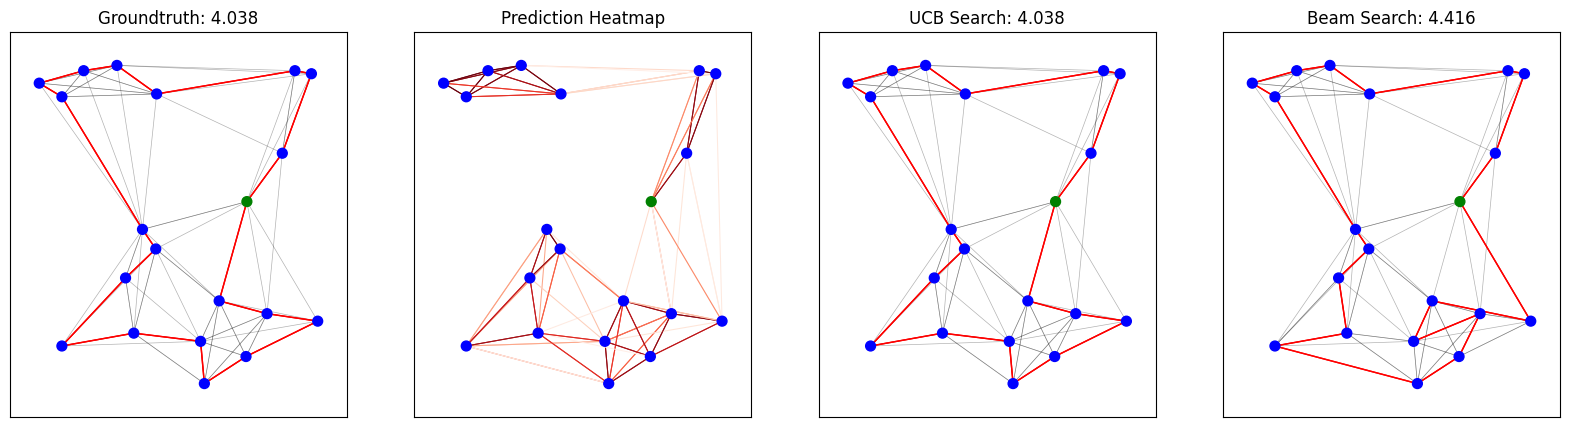

In [52]:
if notebook_mode==True:
    # Set evaluation mode
    net.eval()
    
    batch_size = 1
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    beam_size = config.beam_size
    test_filepath = config.test_filepath
    dataset = iter(GoogleTSPReader(num_nodes, num_neighbors, batch_size, test_filepath))
    batch = next(dataset)

    with torch.no_grad():
        # Convert batch to torch Variables

        edges_k_means = Variable(torch.LongTensor(batch.edges).type(dtypeFloat), requires_grad=False)
        edges_dist = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeFloat), requires_grad=False)
        nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
        y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeFloat), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeFloat), requires_grad=False)
        
        # Compute class weights (if uncomputed)
        if type(edge_cw) != torch.Tensor:
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        
        # Forward pass
        y_preds, loss = net.forward(nodes_coord, edges_dist, edges_k_means, y_edges, edge_cw)
        
        y_UCB = 1- F.softmax(y_preds, dim=-1)
        
        y_UCB = y_UCB[:, :, :, 0]
        # TSP_UCB = UCBSearch_with_batch(y_UCB, edges_dist)
        bs = beamSearch_with_batch02(y_UCB, edges_dist,  max_trials=max_trails_for_decoding)
        TSP_UCB2 = UCBSearch_with_batch_UCB2(y_UCB, edges_dist, max_trials=max_trails_for_decoding)
        
                    
        print("The gap to optimality for UCB is ", 100*compute_optimal_tour_lenght(edges_dist, y_edges, y_preds, TSP_UCB2), "‰")
        print("The gap to optimality for Beam Search is ", 100*compute_optimal_tour_lenght(edges_dist, y_edges, y_preds, bs), "‰")
        plot_predictions_two_methods(nodes_coord, edges_k_means, edges_dist, y_edges, y_preds, TSP_UCB2, bs, num_plots=batch_size)
        

In [18]:
config_path_t = "configs/default50.json"
config_t = get_config(config_path_t)
print("Loaded {}:\n{}".format(config_path_t, config_t))

Loaded configs/default50.json:
{'expt_name': 'deafult', 'gpu_id': '0', 'train_filepath': './data/tsp50_train_concorde.txt', 'val_filepath': './data/tsp50_val_concorde.txt', 'test_filepath': './data/tsp50_test_concorde.txt', 'num_nodes': 50, 'num_neighbors': 15, 'node_dim': 2, 'voc_nodes_in': 2, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 2, 'beam_size': 10, 'hidden_dim': 50, 'num_layers': 3, 'mlp_layers': 2, 'aggregation': 'mean', 'max_epochs': 15, 'val_every': 5, 'test_every': 100, 'batch_size': 15, 'batches_per_epoch': 16, 'accumulation_steps': 1, 'learning_rate': 0.001, 'decay_rate': 1.01}


Number of batches of size 15: 66666
Batch generation took: 0.059 sec
edges: (15, 50, 50)
edges_values: (15, 50, 50)
edges_targets: (15, 50, 50)
nodes: (15, 50)
nodes_target: (15, 50)
nodes_coord: (15, 50, 2)
tour_nodes: (15, 50)
tour_len: (15,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


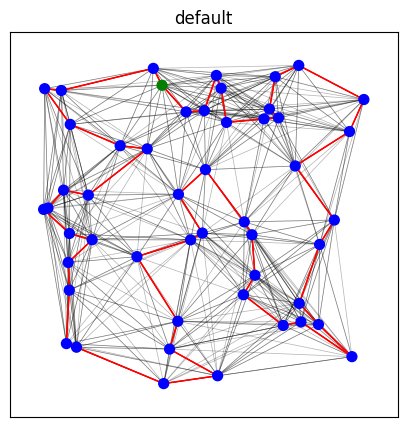

In [21]:
if notebook_mode:
    num_nodes_t = config_t.num_nodes
    num_neighbors_t = config_t.num_neighbors
    batch_size_t = config_t.batch_size
    train_filepath_t = config_t.train_filepath
    dataset_t = GoogleTSPReader(num_nodes_t, num_neighbors_t, batch_size_t, train_filepath_t)
    print("Number of batches of size {}: {}".format(batch_size_t, dataset_t.max_iter))

    t = time.time()
    batch = next(iter(dataset_t))  # Generate a batch of TSPs
    print("Batch generation took: {:.3f} sec".format(time.time() - t))

    print("edges:", batch.edges.shape)
    print("edges_values:", batch.edges_values.shape)
    print("edges_targets:", batch.edges_target.shape)
    print("nodes:", batch.nodes.shape)
    print("nodes_target:", batch.nodes_target.shape)
    print("nodes_coord:", batch.nodes_coord.shape)
    print("tour_nodes:", batch.tour_nodes.shape)
    print("tour_len:", batch.tour_len.shape)

    idx = 0
    f = plt.figure(figsize=(5, 5))
    a = f.add_subplot(111)
    plot_tsp(a, batch.nodes_coord[idx], batch.edges[idx], batch.edges_values[idx], batch.edges_target[idx])
    print(batch.edges_target[idx])

In [22]:
import random
from scipy.spatial.distance import pdist, squareform

def divise_the_TSP(batch, n_instances, n_nodes):
    """_summary_

    Args:
        batch (the TSP): shape (n_nodes) ? 
        n_instances (n): _description_
        n_nodes (_type_): _description_
    """
    nodes_original_TSP = batch.edges.shape[1]
    extracts = []
    TSP_instance = []
    for i in range(n_instances):
        extraction = random.sample(range(nodes_original_TSP), n_nodes)
        extraction.sort()
        extracts.append(extraction)
        edges_k_means =  batch.edges[0]
        extract_edges_k_means = edges_k_means[np.ix_(extraction, extraction)]
        edges_dist =  batch.edges_values[0]
        extract_edges_dist = edges_dist[np.ix_(extraction, extraction)]
        nodes = batch.nodes_coord[0]
        nodes_coord_extraction = nodes[np.isin(np.arange(nodes.shape[0]), extraction), :]
        
        extract_edges_k_means = Variable(torch.LongTensor(extract_edges_k_means).type(dtypeFloat), requires_grad=False).unsqueeze(0)
        extract_edges_dist = Variable(torch.FloatTensor(extract_edges_dist).type(dtypeFloat), requires_grad=False).unsqueeze(0)
        nodes_coord_extraction = Variable(torch.FloatTensor(nodes_coord_extraction).type(dtypeFloat), requires_grad=False).unsqueeze(0)
        
        TSP_instance.append([extract_edges_k_means, extract_edges_dist, nodes_coord_extraction])
    
    return TSP_instance, extracts

def divise_the_TSP3(batch, n_instances, n_nodes):
    nodes_original_TSP = batch.edges.shape[1]
    extracts = []
    TSP_instance = []
    k_idx = k_plus_proches_points(batch.edges_values[0], n_nodes - 1)
    for i in range(n_instances):
        idx = random.randint(0, nodes_original_TSP -1)
        print('idx : ', idx, )
        extraction = k_idx[idx]
        # extraction = random.sample(range(nodes_original_TSP), n_nodes)
        extraction.sort()
        extracts.append(extraction)
        edges_k_means =  batch.edges[0]
        extract_edges_k_means = edges_k_means[np.ix_(extraction, extraction)]
        # edges_dist =  batch.values[0]
        # extract_edges_dist = edges_dist[np.ix_(extraction, extraction)]
        nodes = batch.nodes_coord[0]
        nodes_coord_extraction = nodes[np.isin(np.arange(nodes.shape[0]), extraction), :]
        # nodes_coord_extraction = ( nodes_coord_extraction-np.min(nodes_coord_extraction) )/ (np.max(nodes_coord_extraction)- np.min(nodes_coord_extraction))
        
        # extract_edges_dist = squareform(pdist(nodes_coord_extraction, metric='euclidean'))
        
        extract_edges_k_means = Variable(torch.LongTensor(extract_edges_k_means).type(dtypeFloat), requires_grad=False).unsqueeze(0)
        extract_edges_dist = Variable(torch.FloatTensor(extract_edges_dist).type(dtypeFloat), requires_grad=False).unsqueeze(0)
        nodes_coord_extraction = Variable(torch.FloatTensor(nodes_coord_extraction).type(dtypeFloat), requires_grad=False).unsqueeze(0)
        
        TSP_instance.append([extract_edges_k_means, extract_edges_dist, nodes_coord_extraction])
    
    return TSP_instance, extracts

def k_plus_proches_points(dist, k):
    # dist = dist.numpy()
    indices_proches = np.argsort(dist, axis=1)[:, :k+1]
    return indices_proches



def divise_the_TSP2(batch, n_instances, n_nodes):
    """_summary_

    Args:
        batch (the TSP): shape (n_nodes) ? 
        n_instances (n): _description_
        n_nodes (_type_): _description_
    """
    nodes_original_TSP = batch.edges.shape[1]
    extracts = []
    TSP_instance = []
    for i in range(nodes_original_TSP - n_nodes + 1):
        extraction = [i + j for j in range(n_nodes)]
        extraction.sort()
        extracts.append(extraction)
        edges_k_means =  batch.edges[0]
        extract_edges_k_means = edges_k_means[np.ix_(extraction, extraction)]
        edges_dist =  batch.edges[0]
        extract_edges_dist = edges_dist[np.ix_(extraction, extraction)]
        nodes = batch.nodes_coord[0]
        nodes_coord_extraction = nodes[np.isin(np.arange(nodes.shape[0]), extraction), :]
        
        extract_edges_k_means = Variable(torch.LongTensor(extract_edges_k_means).type(dtypeFloat), requires_grad=False).unsqueeze(0)
        extract_edges_dist = Variable(torch.FloatTensor(extract_edges_dist).type(dtypeFloat), requires_grad=False).unsqueeze(0)
        nodes_coord_extraction = Variable(torch.FloatTensor(nodes_coord_extraction).type(dtypeFloat), requires_grad=False).unsqueeze(0)
        
        TSP_instance.append([extract_edges_k_means, extract_edges_dist, nodes_coord_extraction])
        
    return TSP_instance, extracts
        
def aggregate_result(tab_y_pred, tab_extrac, true_size):
    counts = np.zeros((true_size, true_size))
    new_tab = []
    y_pred_f = np.zeros((true_size, true_size))
    for i in range(len(tab_extrac)):
        temp = np.zeros((true_size, true_size))
        temp[np.ix_(tab_extrac[i], tab_extrac[i])] = tab_y_pred[i].numpy()
        new_tab.append(temp)
        y_pred_f += temp
        counts += np.where(temp != 0, 1, 0)
    # Si on a pas de valeur on initialise a 1/2:
    no_val = np.where(temp == 0, 0, 1/true_size)
    no_val = np.where(temp == 0, 0, 0)
    counts += np.where(counts == 0, 1, 0)
    y_pred_f = y_pred_f/counts + no_val
    # y_pred_f = np.maximum.reduce(new_tab)
    return y_pred_f


In [23]:
from utils.UCB import plot_predictions_two_methods_no_softmax

Batch UCB number :  0  on  1


100%|██████████| 10000/10000 [04:47<00:00, 34.78it/s]


Batch UCB number :  0  on  1


100%|██████████| 1/1 [00:00<00:00, 26.58it/s]


The gap to optimality for UCB is  10.24316882452505 ‰
The gap to optimality for UCB is  370.9817760695337 ‰


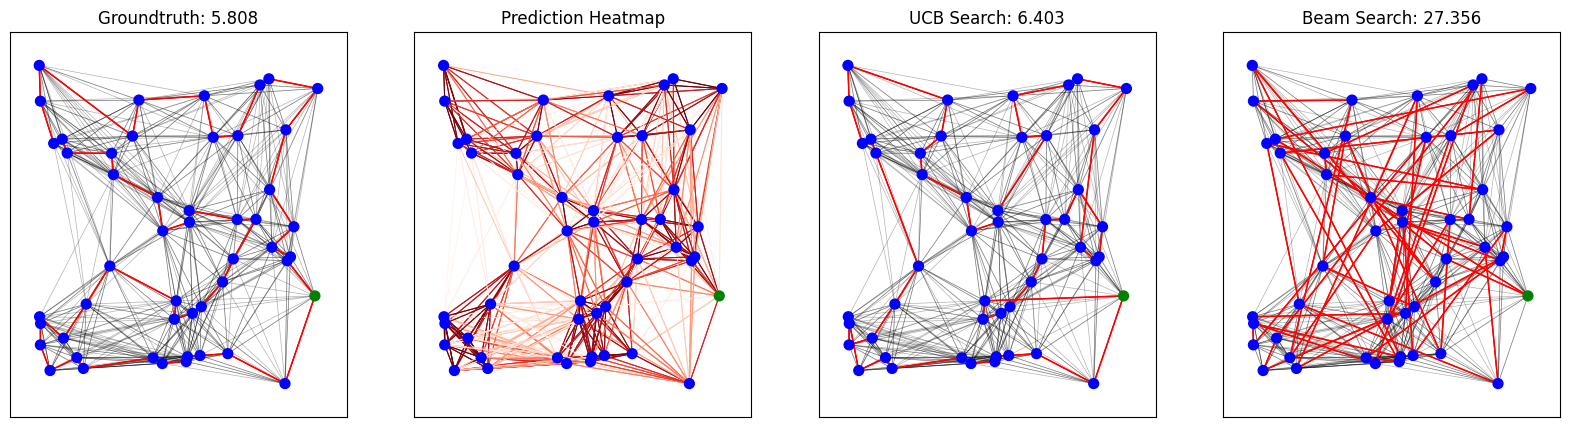

In [143]:
if notebook_mode==True:
    # Set evaluation mode
    net.eval()
    
    batch_size = 1
    num_nodes = config_t.num_nodes
    num_neighbors = config_t.num_neighbors
    beam_size = config_t.beam_size
    test_filepath = config_t.test_filepath
    dataset = iter(GoogleTSPReader(num_nodes, num_neighbors, batch_size, test_filepath))
    batch = next(dataset)
    
    batch_size_o = 1
    num_nodes_o = config.num_nodes
    num_neighbors_o = config.num_neighbors
    beam_size_o = config.beam_size
    test_filepath_o = config.test_filepath
    dataset_o = iter(GoogleTSPReader(num_nodes_o, num_neighbors_o, batch_size_o, test_filepath_o))
    batch_o = next(dataset_o)

    with torch.no_grad():
        y_edges = Variable(torch.LongTensor(batch_o.edges_target).type(dtypeFloat), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch_o.nodes_target).type(dtypeFloat), requires_grad=False)
        
        # Compute class weights (if uncomputed)
        if type(edge_cw) != torch.Tensor:
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

    n_instances = 100_000
    n_nodes = 20

    with torch.no_grad():
        # Convert batch to torch Variables
        tsp_intances , tab_extrac = divise_the_TSP(batch, n_instances, n_nodes)
        
        tab_y_preds = []
        
        # y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeFloat), requires_grad=False)
        # y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeFloat), requires_grad=False)
        # # Compute class weights (if uncomputed)
        # if type(edge_cw) != torch.Tensor:
        #     edge_labels = y_edges.cpu().numpy().flatten()
        #     edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        
        for i in range(len(tsp_intances)):
            edges_k_means = tsp_intances[i][0]
            edges_dist = tsp_intances[i][1]
            nodes_coord = tsp_intances[i][2]
            # print(i)
            # y_preds_temp = net.forward_without_train(nodes_coord, edges_dist, edges_k_means)
            y_preds_temp, loss = net.forward(nodes_coord, edges_dist, edges_k_means, y_edges, edge_cw)        
            # y_preds_temp = net.forward_without_train(nodes_coord, edges_dist, edges_k_means)
            y_preds_temp = 1 - F.softmax(y_preds_temp, dim=-1)
            y_preds_temp = y_preds_temp[:, :, :, 0]
            mean = y_preds_temp
            tab_y_preds += y_preds_temp
        
        edges_dist = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        
        y_preds = aggregate_result(tab_y_preds, tab_extrac, num_nodes)
        # print(y_preds)
        y_preds = np.expand_dims(y_preds, axis=0)
        # y_UCB = 1 - F.softmax(y_preds, dim=-1)
        y_preds = torch.from_numpy(y_preds)
        shape_y = y_preds.shape
        y_preds_r = torch.randn(shape_y)
        
        # y_UCB = y_UCB[:, :, :, 0]
        # TSP_UCB = UCBSearch_with_batch(y_UCB, edges_dist)
        TSP_UCB2 = UCBSearch_with_batch_UCB2(y_preds, edges_dist, max_trials=10_000)
        TSP_UCB3 = UCBSearch_with_batch_UCB2(y_preds_r, edges_dist, max_trials=1)
        # TSP_UCB2 = UCBSearch_with_batch_UCB2(y_preds, edges_dist, max_trials=2)
        # bs = beamSearch_with_batch02(y_preds, edges_dist,  max_trials=max_trails_for_decoding)
        
        edges_k_means = Variable(torch.LongTensor(batch.edges).type(dtypeFloat), requires_grad=False)
        edges_dist = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeFloat), requires_grad=False)
        nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
        y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeFloat), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeFloat), requires_grad=False)
        
        # Compute class weights (if uncomputed)
        if type(edge_cw) != torch.Tensor:
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
                    
        print("The gap to optimality for UCB is ", 100*compute_optimal_tour_lenght(edges_dist, y_edges, y_preds, TSP_UCB2), "‰")
        print("The gap to optimality for UCB is ", 100*compute_optimal_tour_lenght(edges_dist, y_edges, y_preds, TSP_UCB3), "‰")
        # print("The gap to optimality for Beam Search is ", 100*compute_optimal_tour_lenght(edges_dist, y_edges, y_preds, bs), "‰")
        plot_predictions_two_methods_no_softmax(nodes_coord, edges_k_means, edges_dist, y_edges, y_preds, TSP_UCB2, TSP_UCB3, num_plots=batch_size)
        

Batch Beam Search number :  0  on  1


100%|██████████| 1000/1000 [00:27<00:00, 36.95it/s]


Batch UCB number :  0  on  1


100%|██████████| 1000/1000 [00:34<00:00, 29.40it/s]


The gap to optimality for UCB is  10.208060827422516 ‰
The gap to optimality for UCB is  300.41092211167165 ‰


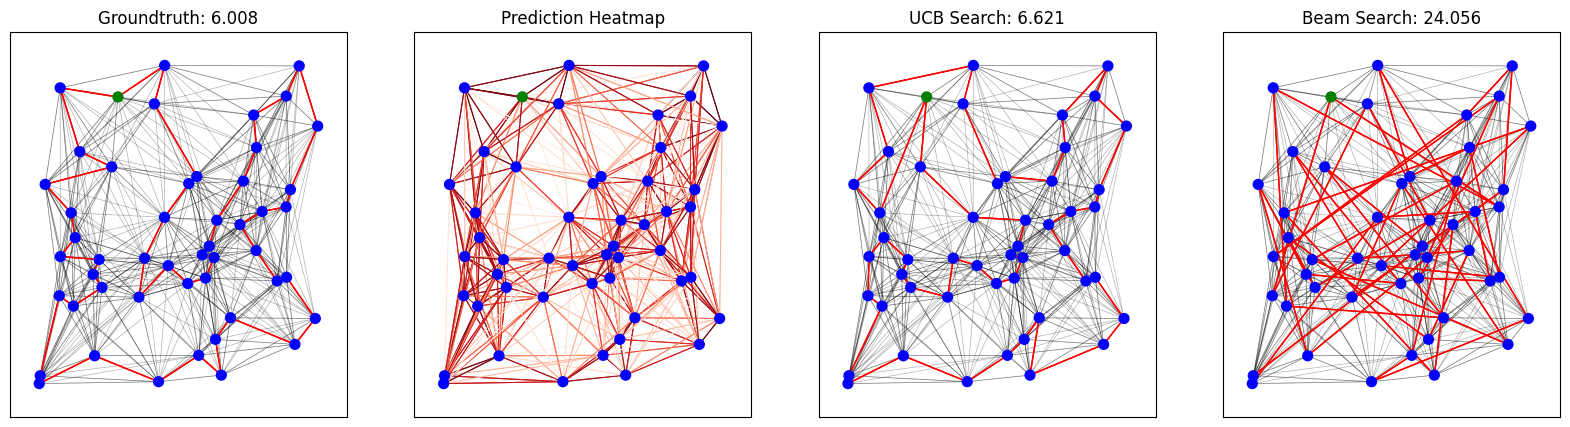

In [54]:
if notebook_mode==True:
    # Set evaluation mode
    net.eval()
    
    batch_size = 1
    num_nodes = config_t.num_nodes
    num_neighbors = config_t.num_neighbors
    beam_size = config_t.beam_size
    test_filepath = config_t.test_filepath
    dataset = iter(GoogleTSPReader(num_nodes, num_neighbors, batch_size, test_filepath))
    batch = next(dataset)
    
    batch_size_o = 1
    num_nodes_o = config.num_nodes
    num_neighbors_o = config.num_neighbors
    beam_size_o = config.beam_size
    test_filepath_o = config.test_filepath
    dataset_o = iter(GoogleTSPReader(num_nodes_o, num_neighbors_o, batch_size_o, test_filepath_o))
    batch_o = next(dataset_o)

    with torch.no_grad():
        y_edges = Variable(torch.LongTensor(batch_o.edges_target).type(dtypeFloat), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch_o.nodes_target).type(dtypeFloat), requires_grad=False)
        
        # Compute class weights (if uncomputed)
        if type(edge_cw) != torch.Tensor:
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

    n_instances = 60
    n_nodes = 20

    with torch.no_grad():
        # Convert batch to torch Variables
        tsp_intances , tab_extrac = divise_the_TSP(batch, n_instances, n_nodes)
        
        tab_y_preds = []
        
        # y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeFloat), requires_grad=False)
        # y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeFloat), requires_grad=False)
        # # Compute class weights (if uncomputed)
        # if type(edge_cw) != torch.Tensor:
        #     edge_labels = y_edges.cpu().numpy().flatten()
        #     edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        
        for i in range(len(tsp_intances)):
            edges_k_means = tsp_intances[i][0]
            edges_dist = tsp_intances[i][1]
            nodes_coord = tsp_intances[i][2]
            # print(i)
            # y_preds_temp = net.forward_without_train(nodes_coord, edges_dist, edges_k_means)
            y_preds_temp, loss = net.forward(nodes_coord, edges_dist, edges_k_means, y_edges, edge_cw)        
            # y_preds_temp = net.forward_without_train(nodes_coord, edges_dist, edges_k_means)
            y_preds_temp = 1 - F.softmax(y_preds_temp, dim=-1)
            y_preds_temp = y_preds_temp[:, :, :, 0]
            mean = y_preds_temp
            tab_y_preds += y_preds_temp
        
        edges_dist = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        
        y_preds = aggregate_result(tab_y_preds, tab_extrac, num_nodes)
        # print(y_preds)
        y_preds = np.expand_dims(y_preds, axis=0)
        # y_UCB = 1 - F.softmax(y_preds, dim=-1)
        y_preds = torch.from_numpy(y_preds)

        
        # y_UCB = y_UCB[:, :, :, 0]
        # TSP_UCB = UCBSearch_with_batch(y_UCB, edges_dist)
        bs = beamSearch_with_batch02(y_preds, edges_dist,  max_trials=max_trails_for_decoding)
        TSP_UCB2 = UCBSearch_with_batch_UCB2(y_preds, edges_dist, max_trials=max_trails_for_decoding)
        # TSP_UCB2 = UCBSearch_with_batch_UCB2(y_preds, edges_dist, max_trials=2)
        
        
        edges_k_means = Variable(torch.LongTensor(batch.edges).type(dtypeFloat), requires_grad=False)
        edges_dist = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeFloat), requires_grad=False)
        nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
        y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeFloat), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeFloat), requires_grad=False)
        
        # Compute class weights (if uncomputed)
        if type(edge_cw) != torch.Tensor:
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
                    
        print("The gap to optimality for UCB is ", 100*compute_optimal_tour_lenght(edges_dist, y_edges, y_preds, TSP_UCB2), "‰")
        print("The gap to optimality for UCB is ", 100*compute_optimal_tour_lenght(edges_dist, y_edges, y_preds, TSP_UCB3), "‰")
        # print("The gap to optimality for Beam Search is ", 100*compute_optimal_tour_lenght(edges_dist, y_edges, y_preds, bs), "‰")
        plot_predictions_two_methods_no_softmax(nodes_coord, edges_k_means, edges_dist, y_edges, y_preds, TSP_UCB2, TSP_UCB3, num_plots=batch_size)
        

20


In [46]:
if notebook_mode==True:
    # Set evaluation mode
    net.eval()
    
    batch_size = 1
    num_nodes = config_t.num_nodes
    num_neighbors = config_t.num_neighbors
    beam_size = config_t.beam_size
    test_filepath = config_t.test_filepath
    dataset = iter(GoogleTSPReader(num_nodes, num_neighbors, batch_size, test_filepath))
    batch = next(dataset)
    
    batch_size_o = 1
    num_nodes_o = config.num_nodes
    num_neighbors_o = config.num_neighbors
    beam_size_o = config.beam_size
    test_filepath_o = config.test_filepath
    dataset_o = iter(GoogleTSPReader(num_nodes_o, num_neighbors_o, batch_size_o, test_filepath_o))
    batch_o = next(dataset_o)

    with torch.no_grad():
        y_edges = Variable(torch.LongTensor(batch_o.edges_target).type(dtypeFloat), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch_o.nodes_target).type(dtypeFloat), requires_grad=False)
        
        # Compute class weights (if uncomputed)
        if type(edge_cw) != torch.Tensor:
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

    n_instances = 100
    n_nodes = 20
    tab_length = []
    tab_n_instance = []

    with torch.no_grad():
        # Convert batch to torch Variables
        tsp_intances , tab_extrac = divise_the_TSP(batch, n_instances, n_nodes)
        
        tab_y_preds = []
        
        # y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeFloat), requires_grad=False)
        # y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeFloat), requires_grad=False)
        # # Compute class weights (if uncomputed)
        # if type(edge_cw) != torch.Tensor:
        #     edge_labels = y_edges.cpu().numpy().flatten()
        #     edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        
        for i in range(len(tsp_intances)):
            edges_k_means = tsp_intances[i][0]
            edges_dist = tsp_intances[i][1]
            nodes_coord = tsp_intances[i][2]
            # print(i)
            # y_preds_temp = net.forward_without_train(nodes_coord, edges_dist, edges_k_means)
            y_preds_temp, loss = net.forward(nodes_coord, edges_dist, edges_k_means, y_edges, edge_cw)        
            # y_preds_temp = net.forward_without_train(nodes_coord, edges_dist, edges_k_means)
            y_preds_temp = 1 - F.softmax(y_preds_temp, dim=-1)
            y_preds_temp = y_preds_temp[:, :, :, 0]
            mean = y_preds_temp
            tab_y_preds += y_preds_temp

            if i != 0 :
                edges_dist_f = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
                
                y_preds = aggregate_result(tab_y_preds, tab_extrac[:i], num_nodes)
                # print(y_preds)
                y_preds = np.expand_dims(y_preds, axis=0)
                # y_UCB = 1 - F.softmax(y_preds, dim=-1)
                y_preds = torch.from_numpy(y_preds)
                shape_y = y_preds.shape
                y_preds_r = torch.randn(shape_y)
                
                # y_UCB = y_UCB[:, :, :, 0]
                # TSP_UCB = UCBSearch_with_batch(y_UCB, edges_dist)
                TSP_UCB2 = UCBSearch_with_batch_UCB2(y_preds, edges_dist_f, max_trials=100)
                # TSP_UCB2 = UCBSearch_with_batch_UCB2(y_preds, edges_dist, max_trials=2)
                # bs = beamSearch_with_batch02(y_preds, edges_dist,  max_trials=max_trails_for_decoding)
                
                edges_k_means_f = Variable(torch.LongTensor(batch.edges).type(dtypeFloat), requires_grad=False)
                edges_dist_f = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
                nodes_coord_f = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
                y_edges_f = Variable(torch.LongTensor(batch.edges_target).type(dtypeFloat), requires_grad=False)
                    
                tab_length.append(100*compute_optimal_tour_lenght(edges_dist_f, y_edges_f, y_preds, TSP_UCB2))
                tab_n_instance.append(i)
                print("it number ", i)
                    
                    
        # print("The gap to optimality for UCB is ", 100*compute_optimal_tour_lenght(edges_dist, y_edges, y_preds, TSP_UCB2), "‰")
        # print("The gap to optimality for UCB is ", 100*compute_optimal_tour_lenght(edges_dist, y_edges, y_preds, TSP_UCB3), "‰")
        # # print("The gap to optimality for Beam Search is ", 100*compute_optimal_tour_lenght(edges_dist, y_edges, y_preds, bs), "‰")
        # plot_predictions_two_methods_no_softmax(nodes_coord, edges_k_means, edges_dist, y_edges, y_preds, TSP_UCB2, TSP_UCB3, num_plots=batch_size)
        

Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.93it/s]


it number  1
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 32.87it/s]


it number  2
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 29.58it/s]


it number  3
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 31.38it/s]


it number  4
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


it number  5
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 33.82it/s]


it number  6
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.86it/s]


it number  7
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 34.38it/s]


it number  8
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.72it/s]


it number  9
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.37it/s]


it number  10
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 31.99it/s]


it number  11
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 26.53it/s]


it number  12
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 25.90it/s]


it number  13
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:04<00:00, 24.41it/s]


it number  14
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 30.48it/s]


it number  15
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 30.61it/s]


it number  16
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 31.15it/s]


it number  17
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 26.65it/s]


it number  18
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 29.40it/s]


it number  19
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 32.35it/s]


it number  20
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 31.43it/s]


it number  21
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.96it/s]


it number  22
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 29.99it/s]


it number  23
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 34.20it/s]


it number  24
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 34.80it/s]


it number  25
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 34.69it/s]


it number  26
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.64it/s]


it number  27
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 32.82it/s]


it number  28
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 33.81it/s]


it number  29
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.53it/s]


it number  30
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.45it/s]


it number  31
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 34.71it/s]


it number  32
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 34.17it/s]


it number  33
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.39it/s]


it number  34
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.94it/s]


it number  35
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.27it/s]


it number  36
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.73it/s]


it number  37
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.76it/s]


it number  38
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.79it/s]


it number  39
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.17it/s]


it number  40
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.12it/s]


it number  41
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 34.36it/s]


it number  42
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.86it/s]


it number  43
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 34.66it/s]


it number  44
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.71it/s]


it number  45
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 34.31it/s]


it number  46
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 41.02it/s]


it number  47
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 33.32it/s]


it number  48
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.94it/s]


it number  49
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.38it/s]


it number  50
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 37.27it/s]


it number  51
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 41.17it/s]


it number  52
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 32.68it/s]


it number  53
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.12it/s]


it number  54
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.17it/s]


it number  55
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.89it/s]


it number  56
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.42it/s]


it number  57
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.30it/s]


it number  58
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.45it/s]


it number  59
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.04it/s]


it number  60
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.59it/s]


it number  61
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.31it/s]


it number  62
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.57it/s]


it number  63
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.84it/s]


it number  64
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 34.43it/s]


it number  65
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.39it/s]


it number  66
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.22it/s]


it number  67
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.82it/s]


it number  68
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.81it/s]


it number  69
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.60it/s]


it number  70
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 33.29it/s]


it number  71
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.60it/s]


it number  72
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.30it/s]


it number  73
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 37.00it/s]


it number  74
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.46it/s]


it number  75
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 31.29it/s]


it number  76
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.72it/s]


it number  77
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.58it/s]


it number  78
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.06it/s]


it number  79
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 41.38it/s]


it number  80
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 32.53it/s]


it number  81
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.72it/s]


it number  82
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.55it/s]


it number  83
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.22it/s]


it number  84
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.24it/s]


it number  85
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:03<00:00, 32.84it/s]


it number  86
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.32it/s]


it number  87
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.46it/s]


it number  88
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.17it/s]


it number  89
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.76it/s]


it number  90
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 34.88it/s]


it number  91
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.41it/s]


it number  92
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.67it/s]


it number  93
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.25it/s]


it number  94
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 36.25it/s]


it number  95
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 33.93it/s]


it number  96
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 34.26it/s]


it number  97
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 35.54it/s]


it number  98
Batch UCB number :  0  on  1


100%|██████████| 100/100 [00:02<00:00, 33.62it/s]

it number  99


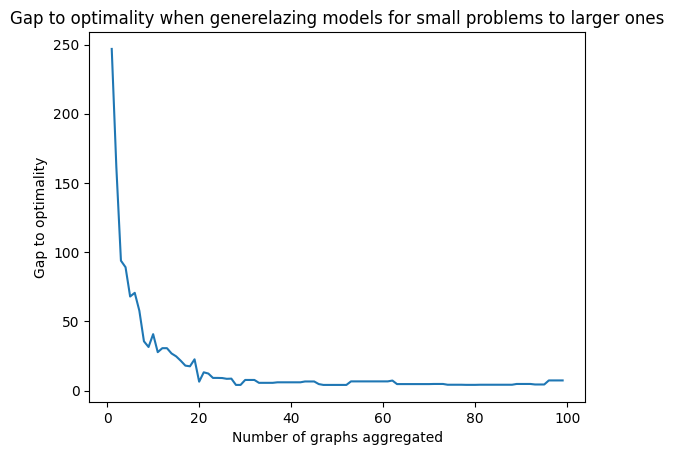

In [51]:
import matplotlib.pyplot as plt


# Tracer le graphique
plt.plot(tab_n_instance, tab_length)  # Utilisez 'o' pour afficher des points
plt.title('Gap to optimality when generelazing models for small problems to larger ones')
plt.xlabel('Number of graphs aggregated')
plt.ylabel('Gap to optimality')
# plt.grid(True)
plt.show()